# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import patsy
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v05.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
current_event = 20

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df.fillna(3, inplace=True)

In [9]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [10]:
last_train_event = 15

In [11]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [12]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [13]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_total_points_element_p3',
 'total_points_element_premium_p3',
 'rolling

In [14]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

### Full feature set

In [15]:
formula_full = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
 ]])

In [16]:
print(formula_full)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + rolling_max_total_points_element + has_high_points_ever_element + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_goals_conceded_element + rolli

In [17]:
y_full, X_full = patsy.dmatrices(formula_full, element_gameweek_df, return_type='matrix')

In [18]:
for train_index, test_index in ps.split():
    X_full_train, X_full_test = X_full[train_index], X_full[test_index]
    y_full_train, y_full_test = y_full[train_index], y_full[test_index]

In [21]:
X_full.design_info.column_names

['Intercept',
 'C(element)[T.2]',
 'C(element)[T.4]',
 'C(element)[T.5]',
 'C(element)[T.6]',
 'C(element)[T.7]',
 'C(element)[T.8]',
 'C(element)[T.9]',
 'C(element)[T.11]',
 'C(element)[T.12]',
 'C(element)[T.13]',
 'C(element)[T.14]',
 'C(element)[T.15]',
 'C(element)[T.17]',
 'C(element)[T.18]',
 'C(element)[T.22]',
 'C(element)[T.23]',
 'C(element)[T.24]',
 'C(element)[T.26]',
 'C(element)[T.27]',
 'C(element)[T.28]',
 'C(element)[T.29]',
 'C(element)[T.31]',
 'C(element)[T.33]',
 'C(element)[T.35]',
 'C(element)[T.36]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.42]',
 'C(element)[T.43]',
 'C(element)[T.45]',
 'C(element)[T.47]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.51]',
 'C(element)[T.54]',
 'C(element)[T.55]',
 'C(element)[T.56]',
 'C(element)[T.57]',
 'C(element)[T.58]',
 'C(element)[T.59]',
 'C(element)[T.60]',
 'C(element)[T.61]',
 'C(element)[T.62]',
 'C(element)[T.66]',
 'C(element)[T.69]',
 'C(el

### Refined feature set

In [22]:
formula_ref = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'expected_total_points_element_home_away',
     'rolling_avg_bps_element',
     'rolling_avg_bps_element_p3',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_total_points_against_opposition_team_element_type_away'
 ]])

In [23]:
print(formula_ref)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + rolling_max_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_goals_conceded_element + rolling_avg_minutes_element_p3 

In [24]:
y_ref, X_ref = patsy.dmatrices(formula_ref, element_gameweek_df, return_type='matrix')

In [25]:
for train_index, test_index in ps.split():
    X_ref_train, X_ref_test = X_ref[train_index], X_ref[test_index]
    y_ref_train, y_ref_test = y_ref[train_index], y_ref[test_index]

In [26]:
X_ref.design_info.column_names

['Intercept',
 'C(element)[T.2]',
 'C(element)[T.4]',
 'C(element)[T.5]',
 'C(element)[T.6]',
 'C(element)[T.7]',
 'C(element)[T.8]',
 'C(element)[T.9]',
 'C(element)[T.11]',
 'C(element)[T.12]',
 'C(element)[T.13]',
 'C(element)[T.14]',
 'C(element)[T.15]',
 'C(element)[T.17]',
 'C(element)[T.18]',
 'C(element)[T.22]',
 'C(element)[T.23]',
 'C(element)[T.24]',
 'C(element)[T.26]',
 'C(element)[T.27]',
 'C(element)[T.28]',
 'C(element)[T.29]',
 'C(element)[T.31]',
 'C(element)[T.33]',
 'C(element)[T.35]',
 'C(element)[T.36]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.42]',
 'C(element)[T.43]',
 'C(element)[T.45]',
 'C(element)[T.47]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.51]',
 'C(element)[T.54]',
 'C(element)[T.55]',
 'C(element)[T.56]',
 'C(element)[T.57]',
 'C(element)[T.58]',
 'C(element)[T.59]',
 'C(element)[T.60]',
 'C(element)[T.61]',
 'C(element)[T.62]',
 'C(element)[T.66]',
 'C(element)[T.69]',
 'C(el

## Selecting features

### Full feature set

In [ ]:
estimator_full = SVR(kernel="linear", C=1, epsilon=1)
selector_full = RFECV(estimator_full, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector_full.fit(X_full, y_full.ravel())

Fitting estimator with 441 features.
Fitting estimator with 440 features.
Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
F

In [57]:
selector_full.support_

array([False, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False, False,  True,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True, False,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True, False,

In [58]:
features_full = patsy.dmatrices(formula_full, element_gameweek_df, return_type='dataframe')[1].columns
selected_features_full = pd.Series(features_full)[selector_full.support_]
print(len(list(selected_features_full)))
list(selected_features_full)

301


['C(element)[T.4]',
 'C(element)[T.6]',
 'C(element)[T.7]',
 'C(element)[T.8]',
 'C(element)[T.9]',
 'C(element)[T.12]',
 'C(element)[T.13]',
 'C(element)[T.14]',
 'C(element)[T.18]',
 'C(element)[T.23]',
 'C(element)[T.24]',
 'C(element)[T.27]',
 'C(element)[T.28]',
 'C(element)[T.33]',
 'C(element)[T.35]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.42]',
 'C(element)[T.43]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.54]',
 'C(element)[T.55]',
 'C(element)[T.56]',
 'C(element)[T.58]',
 'C(element)[T.59]',
 'C(element)[T.60]',
 'C(element)[T.62]',
 'C(element)[T.66]',
 'C(element)[T.69]',
 'C(element)[T.71]',
 'C(element)[T.72]',
 'C(element)[T.73]',
 'C(element)[T.75]',
 'C(element)[T.76]',
 'C(element)[T.77]',
 'C(element)[T.79]',
 'C(element)[T.80]',
 'C(element)[T.84]',
 'C(element)[T.85]',
 'C(element)[T.88]',
 'C(element)[T.90]',
 'C(element)[T.91]',
 'C(element)[T.92]',
 'C(element)[T.95]',
 'C(element)[T.98]

In [59]:
X_full_sel = X_full[:,selector_full.support_]
X_full_train_sel = X_full_train[:,selector_full.support_]
X_full_test_sel = X_full_test[:,selector_full.support_]

### Refined feature set

In [ ]:
estimator_ref = SVR(kernel="linear", C=1, epsilon=1)
selector_ref = RFECV(estimator_ref, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector_ref.fit(X_ref, y_ref.ravel())

In [60]:
selector_ref.support_

array([False, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True, False,
        True, False,  True, False, False, False,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True,  True,  True,  True, False,
        True, False,

In [61]:
features_ref = patsy.dmatrices(formula_ref, element_gameweek_df, return_type='dataframe')[1].columns
selected_features_ref = pd.Series(features_ref)[selector_ref.support_]
print(len(list(selected_features_ref)))
list(selected_features_ref)

275


['C(element)[T.4]',
 'C(element)[T.6]',
 'C(element)[T.7]',
 'C(element)[T.8]',
 'C(element)[T.9]',
 'C(element)[T.12]',
 'C(element)[T.13]',
 'C(element)[T.14]',
 'C(element)[T.18]',
 'C(element)[T.23]',
 'C(element)[T.24]',
 'C(element)[T.27]',
 'C(element)[T.28]',
 'C(element)[T.33]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.42]',
 'C(element)[T.43]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.54]',
 'C(element)[T.55]',
 'C(element)[T.56]',
 'C(element)[T.58]',
 'C(element)[T.60]',
 'C(element)[T.62]',
 'C(element)[T.66]',
 'C(element)[T.69]',
 'C(element)[T.71]',
 'C(element)[T.72]',
 'C(element)[T.73]',
 'C(element)[T.75]',
 'C(element)[T.76]',
 'C(element)[T.77]',
 'C(element)[T.79]',
 'C(element)[T.80]',
 'C(element)[T.82]',
 'C(element)[T.84]',
 'C(element)[T.85]',
 'C(element)[T.88]',
 'C(element)[T.90]',
 'C(element)[T.91]',
 'C(element)[T.92]',
 'C(element)[T.94]',
 'C(element)[T.95]',
 'C(element)[T.98]

In [62]:
X_ref_sel = X_ref[:,selector_ref.support_]
X_ref_train_sel = X_ref_train[:,selector_ref.support_]
X_ref_test_sel = X_ref_test[:,selector_ref.support_]

## Tuning model

### GP tuner

#### Radial basis kernel

##### Full feature set

In [34]:
rbf_full_space = [
    Real(0.1, 5, 'uniform', name='epsilon'),
    Real(100, 10000, 'log-uniform', name='C'),
    Real(10e-6, 10e-4, 'log-uniform', name='gamma'),
]

In [35]:
rbf_full_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_full_space)
def rbf_full_objective(**params):
    rbf_full_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_full_gp_model,
            X_full,
            y_full.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [36]:
rbf_full_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    rbf_full_res_gp = gp_minimize(rbf_full_objective, rbf_full_space, n_calls=30, verbose=2)
    rbf_full_res_gp_arr.append(rbf_full_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.1982
Function value obtained: 9.6654
Current minimum: 9.6654
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.4788
Function value obtained: 10.1569
Current minimum: 9.6654
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.4928
Function value obtained: 10.4345
Current minimum: 9.6654
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6378
Function value obtained: 10.0616
Current minimum: 9.6654
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.1137
Function value obtained: 10.0645
Current minimum: 9.6654
Iterat

In [37]:
for i in rbf_full_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_full_res_gp_arr:
    print(i.x)

9.559173196778618


[1.9211481838863596, 261.58969784296676, 0.0003964967157638536]


##### Refined feature set

In [80]:
rbf_ref_space = [
    Real(1, 3, 'uniform', name='epsilon'),
    Real(10, 1000, 'log-uniform', name='C'),
    Real(0.0001, 0.01, 'log-uniform', name='gamma'),
]

In [81]:
rbf_ref_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_ref_space)
def rbf_ref_objective(**params):
    rbf_ref_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_ref_gp_model,
            X_ref,
            y_ref.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [82]:
rbf_ref_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    rbf_ref_res_gp = gp_minimize(rbf_ref_objective, rbf_ref_space, n_calls=30, verbose=2)
    rbf_ref_res_gp_arr.append(rbf_ref_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2442
Function value obtained: 11.5997
Current minimum: 11.5997
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1717
Function value obtained: 11.3792
Current minimum: 11.3792
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.7139
Function value obtained: 10.8594
Current minimum: 10.8594
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.7711
Function value obtained: 9.9931
Current minimum: 9.9931
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.7097
Function value obtained: 9.9183
Current minimum: 9.9183
Ite

In [83]:
for i in rbf_ref_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_ref_res_gp_arr:
    print(i.x)

9.597492368579724


[1.7721017736179203, 10.0, 0.0009952148157501052]


##### Selected full feature set

In [221]:
rbf_full_sel_space = [
    Real(1, 3, 'uniform', name='epsilon'),
    Real(100, 10000, 'log-uniform', name='C'),
    Real(0.00001, 0.001, 'log-uniform', name='gamma'),
]

In [222]:
rbf_full_sel_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_full_sel_space)
def rbf_full_sel_objective(**params):
    rbf_full_sel_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_full_sel_gp_model,
            X_full_sel,
            y_full.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [223]:
rbf_full_sel_res_gp_arr = []
for i in range(1, 4):
    print('minimisation iteration', i)
    rbf_full_sel_res_gp = gp_minimize(rbf_full_sel_objective, rbf_full_sel_space, n_calls=50, verbose=2)
    rbf_full_sel_res_gp_arr.append(rbf_full_sel_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.2150
Function value obtained: 9.7521
Current minimum: 9.7521
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6264
Function value obtained: 9.6056
Current minimum: 9.6056
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.2789
Function value obtained: 9.5564
Current minimum: 9.5564
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.3362
Function value obtained: 9.6569
Current minimum: 9.5564
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.0810
Function value obtained: 9.6711
Current minimum: 9.5564
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.0624
Function value obtained: 9.4285
Current minimum: 9.4282
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.1889
Function value obtained: 9.4294
Current minimum: 9.4282
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.5151
Function value obtained: 9.4868
Current minimum: 9.4282
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.1526
Function value obtained: 9.4302
Current minimum: 9.4282
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 4.0119
Function value obtained: 9.9229
Current minimum: 9.4282
Iteration No: 46 started. Sea

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.2448
Function value obtained: 9.7953
Current minimum: 9.4278
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.2502
Function value obtained: 9.4770
Current minimum: 9.4278
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 2.5603
Function value obtained: 9.6427
Current minimum: 9.4278
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.9729
Function value obtained: 9.4394
Current minimum: 9.4278
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.1252
Function value obtained: 9.4352
Current minimum: 9.4278
Iteration No: 37 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.7671
Function value obtained: 9.4625
Current minimum: 9.4625
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.6311
Function value obtained: 9.4869
Current minimum: 9.4625
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.1104
Function value obtained: 9.9188
Current minimum: 9.4625
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.5936
Function value obtained: 9.6883
Current minimum: 9.4625
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.0833
Function value obtained: 9.4482
Current minimum: 9.4482
Iteration No: 28 started. Sea

In [224]:
for i in rbf_full_sel_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_full_sel_res_gp_arr:
    print(i.x)

9.426619506475614
9.427845905013227
9.427985462288966


[1.9488680302103305, 236.66009529575533, 0.001]
[1.8728353323816964, 254.42567449670523, 0.001]
[1.9626173294311209, 248.01371773840452, 0.0007617999890597855]


##### Selected refined feature set

In [162]:
rbf_ref_sel_space = [
    Real(0.1, 10, 'uniform', name='epsilon'),
    Real(0.1, 10000, 'log-uniform', name='C'),
    Real(0.00001, 0.01, 'log-uniform', name='gamma'),
]

In [163]:
rbf_ref_sel_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_ref_sel_space)
def rbf_ref_sel_objective(**params):
    rbf_ref_sel_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_ref_sel_gp_model,
            X_ref_sel,
            y_ref.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [167]:
rbf_ref_sel_res_gp_arr = []
for i in range(1, 4):
    print('minimisation iteration', i)
    rbf_ref_sel_res_gp = gp_minimize(rbf_ref_sel_objective, rbf_ref_sel_space, n_calls=50, verbose=2)
    rbf_ref_sel_res_gp_arr.append(rbf_ref_sel_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2088
Function value obtained: 20.3640
Current minimum: 20.3640
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3541
Function value obtained: 15.7642
Current minimum: 15.7642
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.5728
Function value obtained: 10.7325
Current minimum: 10.7325
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0672
Function value obtained: 29.1142
Current minimum: 10.7325
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.9480
Function value obtained: 10.6404
Current minimum: 10.6404


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.5203
Function value obtained: 10.4935
Current minimum: 9.4137
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.8894
Function value obtained: 9.9246
Current minimum: 9.4137
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.5280
Function value obtained: 9.5486
Current minimum: 9.4137
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.8662
Function value obtained: 9.4131
Current minimum: 9.4131
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 3.6684
Function value obtained: 9.4256
Current minimum: 9.4131
Iteration No: 46 started. Se

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 2.9218
Function value obtained: 9.6003
Current minimum: 9.4127
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 2.5124
Function value obtained: 10.1607
Current minimum: 9.4127
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 3.0248
Function value obtained: 9.4010
Current minimum: 9.4010
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.5720
Function value obtained: 9.4236
Current minimum: 9.4010
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 27.9185
Function value obtained: 10.8421
Current minimum: 9.4010
Iteration No: 37 started. 

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.5519
Function value obtained: 9.4414
Current minimum: 9.4336
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.4867
Function value obtained: 9.4352
Current minimum: 9.4336
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.5795
Function value obtained: 9.5573
Current minimum: 9.4336
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 12.4807
Function value obtained: 10.2691
Current minimum: 9.4336
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.3179
Function value obtained: 9.4384
Current minimum: 9.4336
Iteration No: 27 started. S

In [168]:
for i in rbf_ref_sel_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_ref_sel_res_gp_arr:
    print(i.x)

9.405620172769526
9.393791443056857
9.411876867155323


[1.9660313219557233, 402.4071525974152, 0.0006002312915966044]
[2.0420786790313765, 256.30348864838567, 0.0006904234934737864]
[1.9363729322904655, 10000.0, 4.477207968674366e-05]


#### Linear kernel

##### Full feature set

In [35]:
linear_full_space = [
    Real(0.1, 10, 'log-uniform', name='epsilon'),
    Real(0.1, 10000, 'log-uniform', name='C'),
]

In [38]:
linear_full_gp_model = SVR(kernel='linear')

@use_named_args(linear_full_space)
def linear_full_objective(**params):
    linear_full_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            linear_full_gp_model,
            X_full,
            y_full.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [ ]:
linear_full_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    linear_full_res_gp = gp_minimize(linear_full_objective, linear_full_space, n_calls=30, verbose=2)
    linear_full_res_gp_arr.append(linear_full_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 82.2962
Function value obtained: 10.7770
Current minimum: 10.7770
Iteration No: 2 started. Evaluating function at random point.


In [15]:
for i in linear_full_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_full_res_gp_arr:
    print(i.x)

NameError: name 'linear_full_res_gp_arr' is not defined

##### Refined feature set

In [ ]:
linear_ref_space = [
    Real(0.001, 100, 'log-uniform', name='epsilon'),
    Real(0.001, 10000, 'log-uniform', name='C'),
]

In [ ]:
linear_ref_gp_model = SVR(kernel='linear')

@use_named_args(linear_ref_space)
def linear_ref_objective(**params):
    linear_ref_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            linear_ref_gp_model,
            X_ref,
            y_ref.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [ ]:
linear_ref_res_gp_arr = []
for i in range(1, 3):
    print('minimisation iteration', i)
    linear_ref_res_gp = gp_minimize(linear_ref_objective, linear_ref_space, n_calls=30, verbose=2)
    linear_ref_res_gp_arr.append(linear_ref_res_gp)

In [ ]:
for i in linear_ref_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_ref_res_gp_arr:
    print(i.x)

### Grid search

#### Radial basis kernel

##### Full feature set

In [72]:
rbf_full_epsilon = [2.2]
rbf_full_C = [35]
rbf_full_gamma = [0.000175]

rbf_full_parameters = {
    'epsilon': rbf_full_epsilon,
    'C': rbf_full_C,
    'gamma': rbf_full_gamma
}

In [73]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_full_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_rbf.fit(X_full, y_full.ravel())

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] C=34, epsilon=2.2, gamma=0.000175 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=34, epsilon=2.2, gamma=0.000175, total=   3.1s
[CV] C=35, epsilon=2.2, gamma=0.000175 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ................ C=35, epsilon=2.2, gamma=0.000175, total=   2.9s
[CV] C=36, epsilon=2.2, gamma=0.000175 ...............................
[CV] ................ C=36, epsilon=2.2, gamma=0.000175, total=   2.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [34, 35, 36], 'epsilon': [2.2],
                         'gamma': [0.000175]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=2)

In [74]:
gs_model_rbf_full_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_full_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,34,2.2,0.000175,-2.280113,-9.544547
1,35,2.2,0.000175,-2.279472,-9.543827
2,36,2.2,0.000175,-2.279281,-9.544155


In [75]:
gs_model_rbf_full_df[
    gs_model_rbf_full_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_full_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
1,35,2.2,0.000175,-2.279472,-9.543827


##### Refined feature set

In [31]:
rbf_ref_epsilon = [1.9]
rbf_ref_C = [2.9]
rbf_ref_gamma = [0.0040]


rbf_ref_parameters = {
    'epsilon': rbf_ref_epsilon,
    'C': rbf_ref_C,
    'gamma': rbf_ref_gamma
}

In [32]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_ref_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_rbf.fit(X_ref, y_ref.ravel())

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] C=2.9, epsilon=1.9, gamma=0.004 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=2.9, epsilon=1.9, gamma=0.004, total=   3.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [2.9], 'epsilon': [1.9], 'gamma': [0.004]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=2)

In [33]:
gs_model_rbf_ref_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_ref_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,2.9,1.9,0.004,-2.225525,-9.511094


In [34]:
gs_model_rbf_ref_df[
    gs_model_rbf_ref_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_ref_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,2.9,1.9,0.004,-2.225525,-9.511094


##### Selected full feature set

In [261]:
rbf_full_sel_epsilon = [1.9]
rbf_full_sel_C = [205]
rbf_full_sel_gamma = [0.00125]


rbf_full_sel_parameters = {
    'epsilon': rbf_full_sel_epsilon,
    'C': rbf_full_sel_C,
    'gamma': rbf_full_sel_gamma
}

In [262]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_full_sel_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_rbf.fit(X_full_sel, y_ref.ravel())

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] C=205, epsilon=1.9, gamma=0.00125 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=205, epsilon=1.9, gamma=0.00125, total=   2.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [205], 'epsilon': [1.9], 'gamma': [0.00125]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=2)

In [263]:
gs_model_rbf_full_sel_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_full_sel_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,205,1.9,0.00125,-2.219686,-9.422756


In [264]:
gs_model_rbf_full_sel_df[
    gs_model_rbf_full_sel_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_full_sel_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,205,1.9,0.00125,-2.219686,-9.422756


##### Selected refined feature set

In [213]:
rbf_ref_sel_epsilon = [2.0]
rbf_ref_sel_C = [576]
rbf_ref_sel_gamma = [0.0010]

rbf_ref_sel_parameters = {
    'epsilon': rbf_ref_sel_epsilon,
    'C': rbf_ref_sel_C,
    'gamma': rbf_ref_sel_gamma
}

In [214]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_ref_sel_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_rbf.fit(X_ref_sel, y_ref.ravel())

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] C=576, epsilon=2.0, gamma=0.001 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=576, epsilon=2.0, gamma=0.001, total=   2.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [576], 'epsilon': [2.0], 'gamma': [0.001]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=2)

In [215]:
gs_model_rbf_ref_sel_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_ref_sel_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,576,2,0.001,-2.233116,-9.364507


In [216]:
gs_model_rbf_ref_sel_df[
    gs_model_rbf_ref_sel_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_ref_sel_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,576,2,0.001,-2.233116,-9.364507


#### Linear kernel

In [ ]:
linear_epsilon = [1.96, 1.965, 1.97]
linear_C = [18]


linear_parameters = {
    'C': linear_C,
    'epsilon': linear_epsilon
}

In [ ]:
gs_model_linear = GridSearchCV(
    SVR(kernel='linear'),
    linear_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_linear.fit(X_sel, y.ravel())

In [ ]:
gs_model_linear_df = pd.DataFrame(gs_model_linear.cv_results_)[[
    'param_C','param_epsilon',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_linear_df

In [ ]:
gs_model_linear_df[
    gs_model_linear_df['split0_test_neg_mean_squared_error'] == \
    gs_model_linear_df['split0_test_neg_mean_squared_error'].max()]

In [ ]:
9.420

# Evaluating model

## Radial basis kernel

### Full feature set

In [63]:
rbf_full_model = SVR(kernel='rbf', gamma=0.000175, C=35, epsilon=2.2)
rbf_full_model.fit(X_full_train, y_full_train.ravel())

SVR(C=35, cache_size=200, coef0=0.0, degree=3, epsilon=2.2, gamma=0.000175,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [64]:
# get predictions for test set
rbf_full_y_pred = rbf_full_model.predict(X_full_test).flatten()

# calculate cross entropy loss for test set
rbf_full_test_loss = (
    mean_absolute_error(y_full_test, rbf_full_y_pred),
    mean_squared_error(y_full_test, rbf_full_y_pred),
    r2_score(y_full_test, rbf_full_y_pred)
)
rbf_full_test_loss

(2.2794724623884184, 9.543827477367744, 0.08292579161287073)

In [65]:
# refit model on all data
rbf_full_model_all = SVR(kernel='rbf', gamma=0.000175, C=35, epsilon=2.2)
rbf_full_model_all.fit(X_full, y_full.ravel())

SVR(C=35, cache_size=200, coef0=0.0, degree=3, epsilon=2.2, gamma=0.000175,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [66]:
# get predictions for whole set
rbf_full_y_pred_all = rbf_full_model_all.predict(X_full).flatten()

# calculate cross entropy loss for test set
rbf_full_test_loss_all = (
    mean_absolute_error(y_full, rbf_full_y_pred_all),
    mean_squared_error(y_full, rbf_full_y_pred_all),
    r2_score(y_full, rbf_full_y_pred_all)
)
rbf_full_test_loss_all

(2.2053475507576343, 8.542534886604312, 0.10722852227628132)

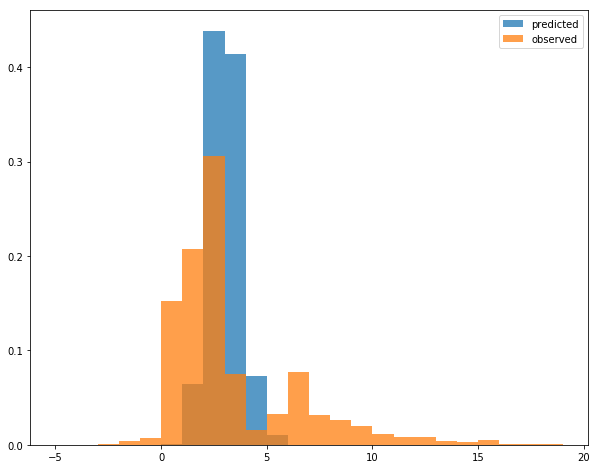

In [67]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_full_y_pred_all), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_full.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

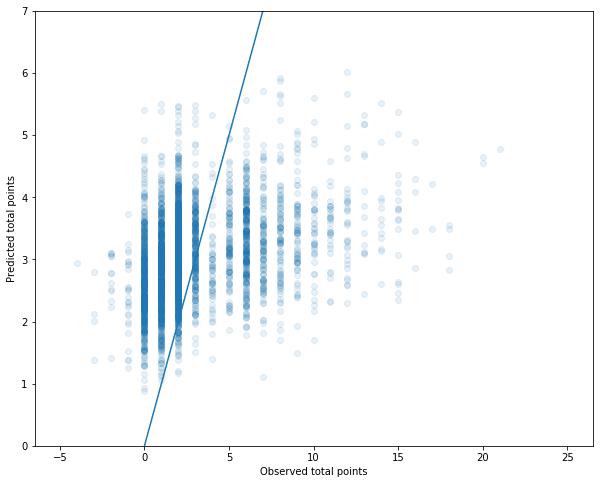

In [68]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_full.ravel()), pd.Series(rbf_full_y_pred_all), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

### Refined feature set

In [69]:
rbf_ref_model = SVR(kernel='rbf', gamma=0.004, C=2.9, epsilon=1.9)
rbf_ref_model.fit(X_ref_train, y_ref_train.ravel())

SVR(C=2.9, cache_size=200, coef0=0.0, degree=3, epsilon=1.9, gamma=0.004,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [70]:
# get predictions for test set
rbf_ref_y_pred = rbf_ref_model.predict(X_ref_test).flatten()

# calculate cross entropy loss for test set
rbf_ref_test_loss = (
    mean_absolute_error(y_ref_test, rbf_ref_y_pred),
    mean_squared_error(y_ref_test, rbf_ref_y_pred),
    r2_score(y_ref_test, rbf_ref_y_pred)
)
rbf_ref_test_loss

(2.2255247900551405, 9.51109431511319, 0.08607114801561244)

In [71]:
# refit model on all data
rbf_ref_model_all = SVR(kernel='rbf', gamma=0.004, C=2.9, epsilon=1.9)
rbf_ref_model_all.fit(X_ref, y_ref.ravel())

SVR(C=2.9, cache_size=200, coef0=0.0, degree=3, epsilon=1.9, gamma=0.004,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [72]:
# get predictions for whole set
rbf_ref_y_pred_all = rbf_ref_model_all.predict(X_ref).flatten()

# calculate cross entropy loss for test set
rbf_ref_test_loss_all = (
    mean_absolute_error(y_ref, rbf_ref_y_pred_all),
    mean_squared_error(y_ref, rbf_ref_y_pred_all),
    r2_score(y_ref, rbf_ref_y_pred_all)
)
rbf_ref_test_loss_all

(2.097116797821993, 8.24850627667461, 0.13795714792013114)

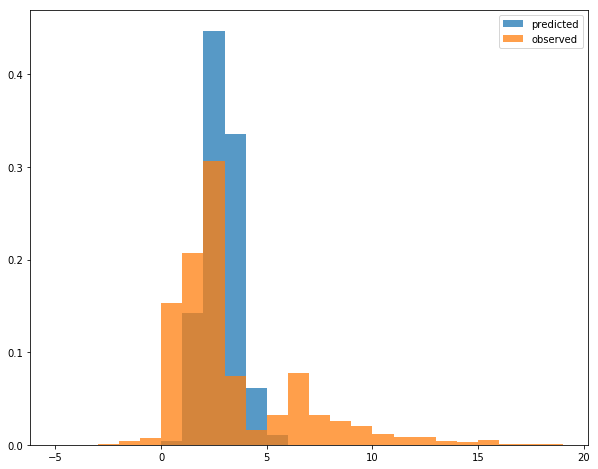

In [73]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_ref_y_pred_all), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_ref.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

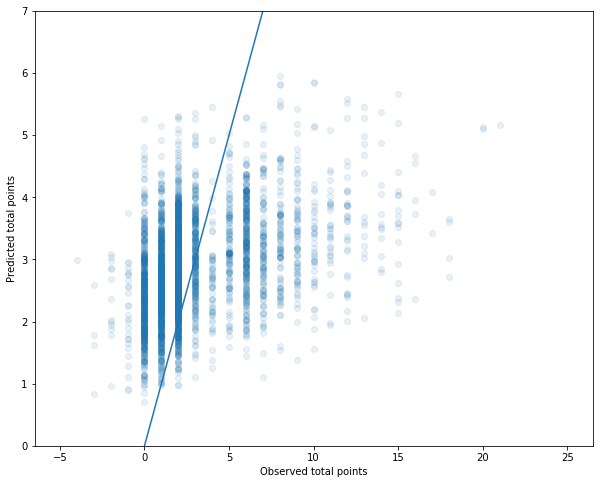

In [74]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_ref.ravel()), pd.Series(rbf_ref_y_pred_all), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

### Selected full feature set

In [75]:
rbf_full_sel_model = SVR(kernel='rbf', gamma=0.00125, C=205, epsilon=1.9)
rbf_full_sel_model.fit(X_full_train_sel, y_full_train.ravel())

SVR(C=205, cache_size=200, coef0=0.0, degree=3, epsilon=1.9, gamma=0.00125,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [76]:
# get predictions for test set
rbf_full_sel_y_pred = rbf_full_sel_model.predict(X_full_test_sel).flatten()

# calculate cross entropy loss for test set
rbf_full_sel_test_loss = (
    mean_absolute_error(y_full_test, rbf_full_sel_y_pred),
    mean_squared_error(y_full_test, rbf_full_sel_y_pred),
    r2_score(y_full_test, rbf_full_sel_y_pred)
)
rbf_full_sel_test_loss

(2.2196861732949764, 9.422755912602003, 0.09455965755177553)

In [77]:
# full_selit model on all data
rbf_full_sel_model_all = SVR(kernel='rbf', gamma=0.00125, C=205, epsilon=1.9)
rbf_full_sel_model_all.fit(X_full_sel, y_full.ravel())

SVR(C=205, cache_size=200, coef0=0.0, degree=3, epsilon=1.9, gamma=0.00125,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
# get predictions for whole set
rbf_full_sel_y_pred_all = rbf_full_sel_model_all.predict(X_full_sel).flatten()

# calculate cross entropy loss for test set
rbf_full_sel_test_loss_all = (
    mean_absolute_error(y_full, rbf_full_sel_y_pred_all),
    mean_squared_error(y_full, rbf_full_sel_y_pred_all),
    r2_score(y_full, rbf_full_sel_y_pred_all)
)
rbf_full_sel_test_loss_all

(2.0044462969223638, 7.595872805891955, 0.2061631963421583)

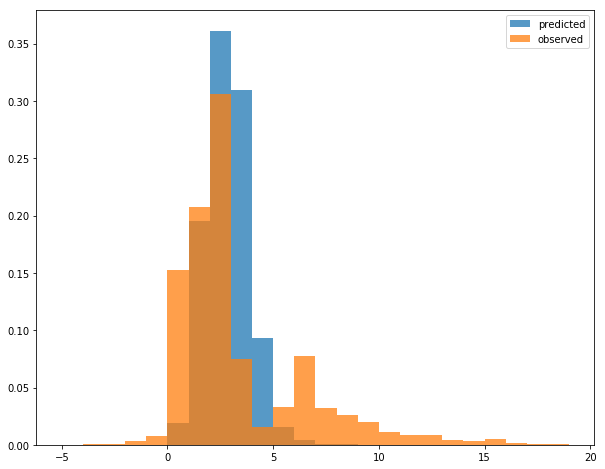

In [79]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_full_sel_y_pred_all), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_full.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

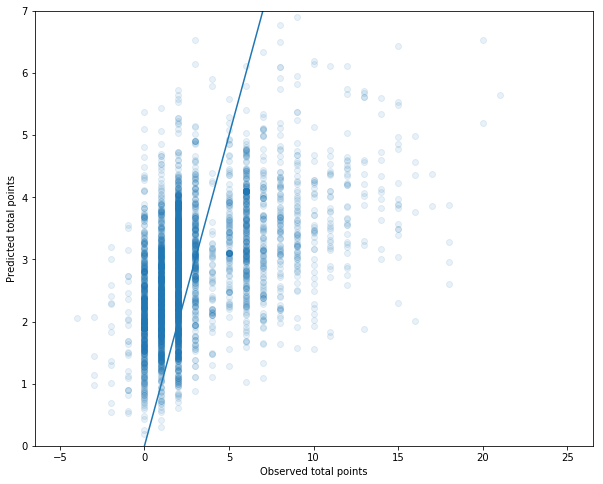

In [80]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_full.ravel()), pd.Series(rbf_full_sel_y_pred_all), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

### Selected refined feature set

In [81]:
rbf_ref_sel_model = SVR(kernel='rbf', gamma=0.001, C=576, epsilon=2)
rbf_ref_sel_model.fit(X_ref_train_sel, y_ref_train.ravel())

SVR(C=576, cache_size=200, coef0=0.0, degree=3, epsilon=2, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [82]:
# get predictions for test set
rbf_ref_sel_y_pred = rbf_ref_sel_model.predict(X_ref_test_sel).flatten()

# calculate cross entropy loss for test set
rbf_ref_sel_test_loss = (
    mean_absolute_error(y_ref_test, rbf_ref_sel_y_pred),
    mean_squared_error(y_ref_test, rbf_ref_sel_y_pred),
    r2_score(y_ref_test, rbf_ref_sel_y_pred)
)
rbf_ref_sel_test_loss

(2.2331163362639987, 9.364506650396365, 0.1001568769224156)

In [83]:
# ref_selit model on all data
rbf_ref_sel_model_all = SVR(kernel='rbf', gamma=0.001, C=576, epsilon=2)
rbf_ref_sel_model_all.fit(X_ref_sel, y_ref.ravel())

SVR(C=576, cache_size=200, coef0=0.0, degree=3, epsilon=2, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [84]:
# get predictions for whole set
rbf_ref_sel_y_pred_all = rbf_ref_sel_model_all.predict(X_ref_sel).flatten()

# calculate cross entropy loss for test set
rbf_ref_sel_test_loss_all = (
    mean_absolute_error(y_ref, rbf_ref_sel_y_pred_all),
    mean_squared_error(y_ref, rbf_ref_sel_y_pred_all),
    r2_score(y_ref, rbf_ref_sel_y_pred_all)
)
rbf_ref_sel_test_loss_all

(2.046105960275648, 7.687969060575502, 0.19653831210368922)

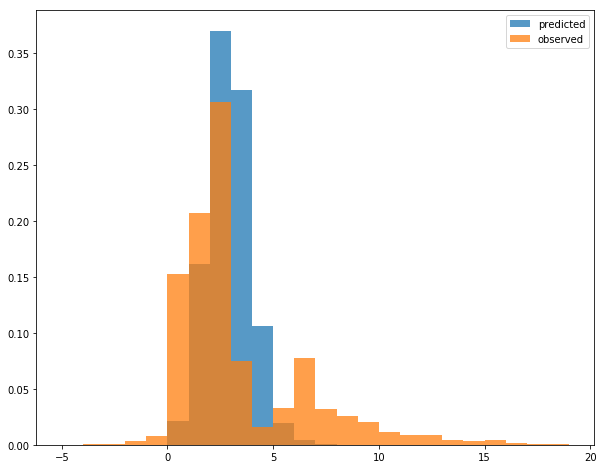

In [85]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_ref_sel_y_pred_all), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_ref.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

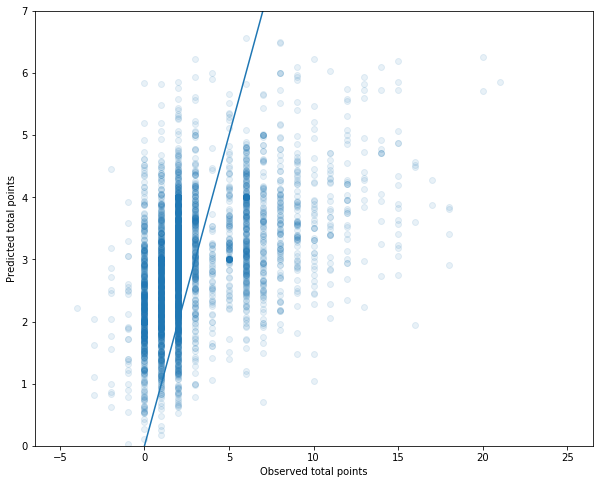

In [86]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_ref.ravel()), pd.Series(rbf_ref_sel_y_pred_all), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Linear basis kernel

In [ ]:
linear_model = SVR(kernel='linear', C=18, epsilon=1.97)
linear_model.fit(X_train_sel, y_train.ravel())

## Summary

In [16]:
pd.DataFrame([
    ('Radius basis SVM regression', rbf_test_loss[0], rbf_test_loss[1], rbf_test_loss[2]),
    ('Linear basis SVM regression', linear_test_loss[0], linear_test_loss[1], linear_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

NameError: name 'rbf_test_loss' is not defined

In [ ]:
pd.DataFrame([
    ('Radius basis SVM regression', rbf_test_loss_full[0], rbf_test_loss_full[1], rbf_test_loss_full[2]),
    ('Linear basis SVM regression', linear_test_loss_full[0], linear_test_loss_full[1], linear_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])